<a href="https://colab.research.google.com/github/ABD-01/Siamese-Triplet/blob/master/Siamese-ORL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

In [8]:
torch.cuda.is_available()

True

In [2]:
PATH = '/content/drive/MyDrive/Colab Notebooks/att_face_dataset/'

In [3]:
class CustomDataset(Dataset):

    def __init__(self, path, transform=transforms.ToTensor()):
        self.dirs = glob.glob(f'{path}*/')
        self.transform = transform
        
        self.total_images = self._get_images(self.dirs, self.transform)

    def _get_images(self, dirs, transform):
        ti = []
        for dir in tqdm(dirs):
#             images = [transform(Image.open(image)).squeeze() for image in glob.glob(f'{dir}*')]
            images = [transform(Image.open(image)) for image in glob.glob(f'{dir}*')]
            ti.append(images)
        return ti
        
    def __len__(self):
        return self.dirs.__len__()
    
    def __getitem__(self,idx):
        return torch.stack(self.total_images[idx], dim=0)

In [6]:
att_dataset = CustomDataset(PATH)

100%|██████████| 40/40 [03:57<00:00,  5.93s/it]


In [9]:
att_dataset[0][0].shape

torch.Size([1, 112, 92])

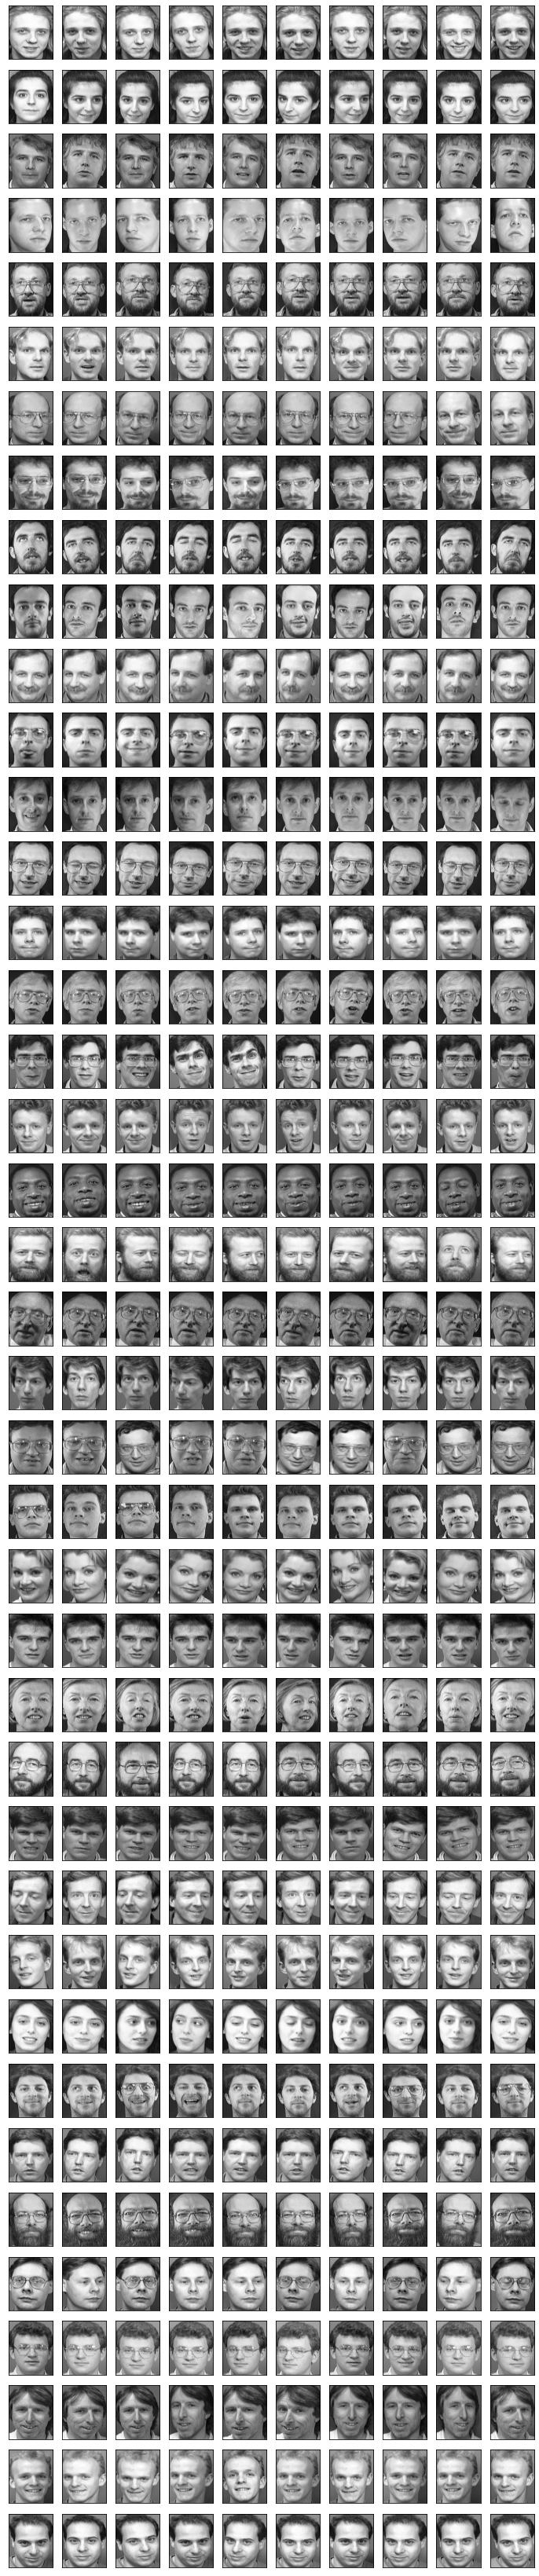

In [10]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()

In [4]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [5]:
def get_random_triplets(embeddings,  targets=None) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''


#     assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)

        for anchor in embedding:
            positive = random.choice(embedding)

            for negatives in embeddings:
                negative = random.choice(negatives)

                triplets.append(torch.stack([anchor, positive, negative], dim=0))

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)

In [11]:
dataset = list(att_dataset)

In [12]:
train = dataset[0:5]

In [13]:
type(train)

list

In [14]:
triplets = get_random_triplets(train)

In [15]:
triplets.shape

torch.Size([200, 3, 1, 112, 92])

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.convnet1 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(7,5))),
                            ('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,3))),
                            ('norm', nn.BatchNorm2d(32)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        # ref : https://discuss.pytorch.org/t/is-it-possible-to-specify-a-name-for-each-layer-when-creating-the-model/33637/2

        self.convnet2 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(64)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))

        self.convnet3 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)),
                            ('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)),
                            ('norm', nn.BatchNorm2d(128)),
                            ('actv', nn.ReLU(inplace=True)),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        
        self.conv     = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        
        self.FCs      = nn.Sequential(OrderedDict([
                            ('FC1', nn.Linear(in_features=3072, out_features=1024)),
                            ('relu1', nn.ReLU(inplace=True)),
                            ('FC2', nn.Linear(in_features=1024, out_features=512)),
                            ('relu2', nn.ReLU(inplace=True)),
                            ('FC3', nn.Linear(in_features=512, out_features=128)),
                            ('relu3', nn.ReLU(inplace=True)),
        ]))
        

        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')  # He-initialization
                # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

    def semi_forward(self, x):
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        x = self.conv(x)
        x = x.view(-1, 6*4*128)
        # x = x.reshape(-1, 10*6*128)
        x = self.FCs(x)
        return x

    def forward(self,triplet):
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

In [17]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(1, 16, kernel_size=(7, 5), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(5, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (actv): Re

In [23]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
if torch.cuda.is_available():
    model = model.cuda()

In [24]:
cost = []

epochs = 50
for epoch in range(epochs):

    triplets = get_random_triplets(train)
    
    if torch.cuda.is_available():
        apn = model(triplets.cuda())
    else:
        apn = model(triplets)

    optimizer.zero_grad()
    loss = triplet_loss(*apn)
    # loss = lossfn(*apn)
    cost.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')

Epoch:[1/50] , Cost : 0.04537716880440712
Epoch:[2/50] , Cost : 0.009904849343001842
Epoch:[3/50] , Cost : 0.0
Epoch:[4/50] , Cost : 0.0
Epoch:[5/50] , Cost : 0.0
Epoch:[6/50] , Cost : 0.0
Epoch:[7/50] , Cost : 0.0
Epoch:[8/50] , Cost : 0.0
Epoch:[9/50] , Cost : 0.0
Epoch:[10/50] , Cost : 0.0
Epoch:[11/50] , Cost : 0.0
Epoch:[12/50] , Cost : 0.0
Epoch:[13/50] , Cost : 0.0
Epoch:[14/50] , Cost : 0.005235346965491772
Epoch:[15/50] , Cost : 0.0017524251015856862
Epoch:[16/50] , Cost : 0.0
Epoch:[17/50] , Cost : 0.0
Epoch:[18/50] , Cost : 0.0
Epoch:[19/50] , Cost : 0.0
Epoch:[20/50] , Cost : 0.0
Epoch:[21/50] , Cost : 0.0
Epoch:[22/50] , Cost : 0.0
Epoch:[23/50] , Cost : 0.0
Epoch:[24/50] , Cost : 0.002687600441277027
Epoch:[25/50] , Cost : 0.0
Epoch:[26/50] , Cost : 0.0
Epoch:[27/50] , Cost : 0.0
Epoch:[28/50] , Cost : 0.0
Epoch:[29/50] , Cost : 0.0
Epoch:[30/50] , Cost : 0.0
Epoch:[31/50] , Cost : 0.0
Epoch:[32/50] , Cost : 0.0
Epoch:[33/50] , Cost : 0.0
Epoch:[34/50] , Cost : 0.0
Epoch:

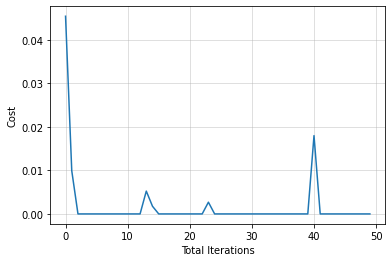

In [27]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(epochs), cost)
plt.grid(alpha=0.5)
plt.show()

In [28]:
apn[0].mean()

tensor(0.3532, device='cuda:0', grad_fn=<MeanBackward0>)

In [29]:
p = (apn[0] - apn[1]).pow(2).sum(-1)
p

tensor([1.5753e+00, 1.5753e+00, 1.5753e+00, 1.5753e+00, 8.9185e-01, 8.9185e-01,
        8.9185e-01, 8.9185e-01, 7.6761e-01, 7.6761e-01, 7.6761e-01, 7.6761e-01,
        2.2574e+00, 2.2574e+00, 2.2574e+00, 2.2574e+00, 1.8170e+00, 1.8170e+00,
        1.8170e+00, 1.8170e+00, 2.1679e+00, 2.1679e+00, 2.1679e+00, 2.1679e+00,
        4.1287e-01, 4.1287e-01, 4.1287e-01, 4.1287e-01, 8.8072e-04, 8.8062e-04,
        8.8072e-04, 8.8062e-04, 1.4520e+00, 1.4520e+00, 1.4520e+00, 1.4520e+00,
        1.3623e+00, 1.3623e+00, 1.3623e+00, 1.3623e+00, 3.6690e+00, 3.6690e+00,
        3.6690e+00, 3.6690e+00, 2.6057e-01, 2.6057e-01, 2.6057e-01, 2.6057e-01,
        1.8548e+00, 1.8548e+00, 1.8548e+00, 1.8548e+00, 5.4702e-01, 5.4702e-01,
        5.4702e-01, 5.4702e-01, 1.2287e+00, 1.2287e+00, 1.2287e+00, 1.2287e+00,
        2.4276e+00, 2.4276e+00, 2.4276e+00, 2.4276e+00, 2.7120e-01, 2.7120e-01,
        2.7120e-01, 2.7120e-01, 3.5547e+00, 3.5547e+00, 3.5547e+00, 3.5547e+00,
        3.3013e+00, 3.3013e+00, 3.3013e+

In [30]:
n = (apn[0] - apn[2]).pow(2).sum(-1)
n

tensor([38.2989, 18.6714,  8.0949, 41.2928, 26.3160, 15.6687, 17.4794, 33.0728,
        17.7352, 18.2389,  8.8949, 36.4342, 30.6721, 16.8567,  5.8324, 33.3991,
        39.0903, 17.9151, 16.9679, 36.0850, 26.2538, 16.3071, 12.8887, 25.9044,
        25.7598, 16.6764, 11.8567, 32.2749, 43.2861, 19.0171, 14.7772, 37.5058,
        24.1109, 15.1676,  8.0424, 38.9776, 37.7774, 18.9562, 22.3683, 32.0177,
        15.4568, 15.8411, 32.9948, 21.3603, 37.8195, 25.1660, 43.0597, 24.1122,
        37.6018, 23.0853, 35.5326, 21.3994, 42.8878, 27.0710, 59.1373, 29.9417,
        25.6853, 21.6972, 34.6190, 23.1455, 19.3282, 13.1852, 32.1778, 19.5666,
        36.1076, 26.5368, 44.1471, 22.1954, 27.8654, 22.0853, 46.3937, 23.9901,
        35.3883, 24.0381, 51.3097, 32.1160, 33.7667, 27.6706, 53.6861, 24.6612,
        15.8676, 28.9859, 17.2064, 20.8727, 15.7883, 13.0531, 15.3097, 10.5084,
        10.6876, 23.2204, 21.3036, 16.5848, 19.2589, 24.0110, 29.3010, 11.2426,
        17.5026, 23.7207, 19.8680, 15.96

In [31]:
p.max() , p.mean() , n.max(), n.mean()

(tensor(5.5206, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(1.5637, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(59.1373, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(26.2007, device='cuda:0', grad_fn=<MeanBackward0>))

In [46]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1)

In [39]:
sample = [model.semi_forward(att_dataset[i][0].unsqueeze(0).cuda()) for i in tqdm(range(10))]


100%|██████████| 10/10 [00:00<00:00, 401.77it/s]


In [40]:
sample = torch.cat(sample)

In [41]:
sample.shape

torch.Size([10, 128])

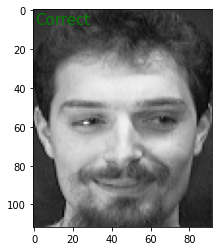

In [94]:
Class = 7
randImg = att_dataset[Class][2]
plt.imshow(randImg.squeeze(), cmap='gray')
renc = model.semi_forward(randImg.unsqueeze(0).cuda())

In [58]:
renc.shape

torch.Size([1, 128])

In [59]:
dis = dist(renc, sample)

In [60]:
dis

tensor([6.3311, 2.7901, 5.9259, 7.3138, 8.9053, 2.9385, 3.3422, 2.6152, 8.7222,
        6.2931], device='cuda:0', grad_fn=<SumBackward1>)

In [61]:
dis.argmin()

tensor(7, device='cuda:0')

In [71]:
data_enc = [model.semi_forward(img.cuda()) for img in tqdm(dataset[:10])]



100%|██████████| 10/10 [00:00<00:00, 203.28it/s]


In [77]:
data_enc[0].shape

torch.Size([10, 128])

In [84]:
pred = [torch.stack([dist(enc,sample).argmin() for enc in data_enc[i]]) for i in range(10)]
print(pred)

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), tensor([2, 2, 2, 2, 2, 4, 2, 2, 9, 4], device='cuda:0'), tensor([3, 3, 3, 9, 3, 9, 5, 8, 5, 8], device='cuda:0'), tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0'), tensor([5, 6, 5, 5, 9, 9, 0, 6, 6, 0], device='cuda:0'), tensor([6, 7, 7, 7, 0, 4, 7, 6, 6, 9], device='cuda:0'), tensor([7, 7, 1, 1, 5, 1, 1, 1, 7, 1], device='cuda:0'), tensor([8, 9, 8, 8, 8, 9, 9, 9, 9, 3], device='cuda:0'), tensor([9, 3, 2, 5, 5, 9, 5, 9, 9, 5], device='cuda:0')]


In [106]:
tc = 0
for i in range(10):
    corr = (pred[i] == i).sum()
    print(corr)
    tc += corr.item()
print('Accuracy = ', tc, '%')

tensor(10, device='cuda:0')
tensor(10, device='cuda:0')
tensor(7, device='cuda:0')
tensor(4, device='cuda:0')
tensor(10, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
Accuracy =  58 %


In [98]:
if pred[0][0] == 0:
    print('Yes')

Yes


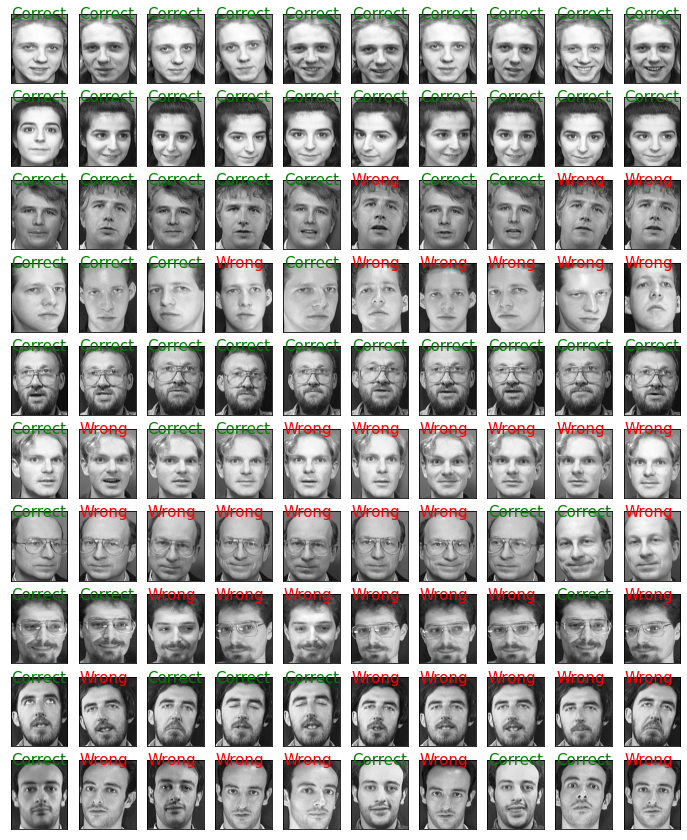

In [104]:
_,axxr = plt.subplots(10,10, figsize=(12,15))
for i in range(10):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
        if pred[i][j] == i:
            axxr[i][j].text(0.5,7,'Correct', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,7,'Wrong', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()